<h1><center>Analiza zastosowania pretrenowanych sieci neuronowych<center><h1>
 

# Opis projektu


Projekt ma na celu sprawdzenie jak można zastosować pretrenowane sieci neuronowe typu konwolucyjnego do diagnostyki COVID-19 na podstawie zdjęć rentgenowskich. 

# Zbór danych


Dane użyte w projekcie pochodzą z projektu COVID-Net, dostępnego w repozytorium https://github.com/lindawangg/COVID-Net. Wszystkie dane w projekcie zostały wygenerowane według instrukcji https://github.com/lindawangg/COVID-Net/blob/master/docs/COVIDx.md.

Zbiór COVIDx składa się z następujących zbiorów:

- https://github.com/ieee8023/covid-chestxray-dataset
- https://github.com/agchung/Figure1-COVID-chestxray-dataset
- https://github.com/agchung/Actualmed-COVID-chestxray-dataset
- https://www.kaggle.com/tawsifurrahman/covid19-radiography-database
- https://www.kaggle.com/c/rsna-pneumonia-detection-challenge (which came from: https://nihcc.app.box.com/v/ChestXray-NIHCC)
- https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70230281

W związku z rozbieżnościami w plikach opisanych w repozytorium, a faktycznymi plikami w tych zbiorach danych, niektóre pliki musiały zostać pominięte, co opisano dalej w punkcie Preprocesing danych.

# Preprocesing danych

W związku z problemami z uruchomieniem wszystkich elementów skryptu przygotowującego dane z repozytorium, niektóre dane zostały pominięte. Dodatkowo całość została podzielona na faoldery z klasami oraz pliki jpg zostały skonwertowane na pliki png.

Aby skompensować brakujące dane (klasa COVID-19 z danych przeznaczonych do testowania) kilka losowy wybranych obrazków ze zbioru trenującego zostało przeniesionych do zbioru testującego.

# Trenowanie modeli

W projekcie zostały użyte pretrenowane sieci konwolucyjne. W celu porównania wytrenowano kilka róznych modeli. Do pretrenowanych modeli zostały dodane dwie warstwy - pulling oraz dense.

Użyte pretrenowane modele:
- MobileNet
- MobileNet V2
- Resnet50
- InceptionResnet V2
- Inception V3

Ze względu na podobne wyniki większości modeli analizowane są tylko 3 z nich.

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import tensorflow as tf

model_224_8_MobileNetV2 = tf.keras.models.load_model('drive/MyDrive/MIO/models/224_8_MobileNetV2.h5')
model_64_16_MobileNetV2 = tf.keras.models.load_model('drive/MyDrive/MIO/models/64_16_MobileNetV2.h5')
model_inception_v3 = tf.keras.models.load_model('drive/MyDrive/MIO/models/ourdata_256_16_inception_v3.h5')

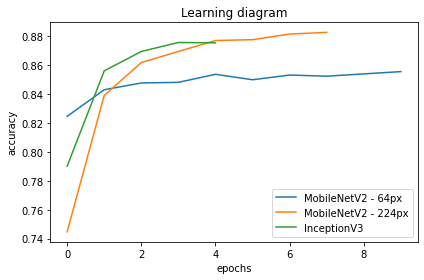

In [91]:
import matplotlib.pyplot as plt

# values from logs
l1 = [0.8246335983276367, 0.8430438041687012, 0.8477365970611572, 0.8481698036193848, 0.8537289500236511, 0.8499747514724731, 0.8532236218452454, 0.8524294495582581, 0.8540177345275879, 0.8556060791015625]
l2 = [0.7447115778923035, 0.8390730023384094, 0.8618872165679932, 0.8695400953292847, 0.8771207928657532, 0.8776983618736267, 0.8815969824790955, 0.8827521204948425]
l3 = [0.790123462677002, 0.856111466884613, 0.8695400953292847, 0.8757490515708923, 0.8755324482917786]

fig, ax = plt.subplots()

plt.plot(l1, label="MobileNetV2 - 64px")
plt.plot(l2, label="MobileNetV2 - 224px")
plt.plot(l3, label="InceptionV3")
plt.legend()

ax.set_xlabel("epochs")
ax.set_ylabel("accuracy")

ax.set_title("Learning diagram")
fig.tight_layout()
plt.show()

## MobileNet V2 - 224, 8

### Parametry
- rozmiar obrazka podawanego przy uczeniu: 224 px
- batch size: 8

In [92]:
model_224_8_MobileNetV2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


## MobileNet V2  - 64, 16

### Parametry
- rozmiar obrazka podawanego przy uczeniu: 64 px
- batch size: 16

In [93]:
model_64_16_MobileNetV2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


## Inception V3

### Parametry
- rozmiar obrazka podawanego przy uczeniu: 256 px
- batch size: 16

In [94]:
model_inception_v3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


# Analiza poszczególnych modeli na zbiorze testowym

In [95]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['normal', 'pneumonia', 'COVID-19']
test_data_path = 'drive/MyDrive/MIO/test'
test_datagen = ImageDataGenerator(rescale=1. / 255)


def plot_confusion_matrix(matrix, labels):
    fig,ax = plt.subplots()
    im = ax.imshow(matrix, cmap=plt.cm.copper)
    n = len(labels)

    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(labels)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(n):
        for j in range(n):
            text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="w")

    ax.set_title("Confusion matrix")
    fig.tight_layout()
    plt.show()

def get_validation_generator(test_data_path, target_names, img_size, batch_size):
  validation_generator = test_datagen.flow_from_directory(
    test_data_path,
    classes=target_names,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
  )
  return validation_generator

## MobileNet V2 - 224, 8

In [96]:
model_name = f'drive/MyDrive/MIO/models/224_8_MobileNetV2.h5'

batch_size = 8
img_size = 224

validation_generator = get_validation_generator(test_data_path, target_names, img_size, batch_size)
model = load_model(model_name)

y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

Found 225 images belonging to 3 classes.


### Accuracy and loss

In [97]:
eval_data = model.evaluate(validation_generator)

29/29 [==============================] - 5s 144ms/step - loss: 0.4646 - accuracy: 0.1422


### Confusion matrix

[[ 2 51 47]
 [ 0 53 47]
 [ 0 11 14]]


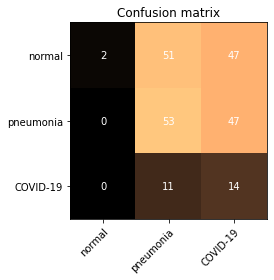

In [98]:
cm = confusion_matrix(validation_generator.classes, y_pred_classes)
print(cm)
plot_confusion_matrix(cm, target_names)

### Classification report

In [99]:
print(classification_report(validation_generator.classes, y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

      normal       1.00      0.02      0.04       100
   pneumonia       0.46      0.53      0.49       100
    COVID-19       0.13      0.56      0.21        25

    accuracy                           0.31       225
   macro avg       0.53      0.37      0.25       225
weighted avg       0.66      0.31      0.26       225



## MobileNet V2  - 64, 16

In [100]:
model_name = f'drive/MyDrive/MIO/models/64_16_MobileNetV2.h5'

batch_size = 16
img_size = 64

validation_generator = get_validation_generator(test_data_path, target_names, img_size, batch_size)
model = load_model(model_name)

y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

Found 225 images belonging to 3 classes.


### Accuracy and loss

In [101]:
eval_data = model.evaluate(validation_generator)

15/15 [==============================] - 4s 246ms/step - loss: 0.5128 - accuracy: 0.1467


### Confusion matrix

[[ 1 60 39]
 [ 2 46 52]
 [ 1 13 11]]


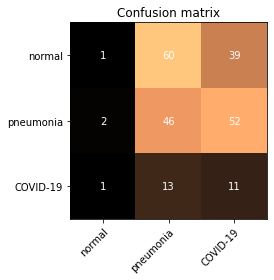

In [102]:
cm = confusion_matrix(validation_generator.classes, y_pred_classes)
print(cm)
plot_confusion_matrix(cm, target_names)

### Classification report

In [103]:
print(classification_report(validation_generator.classes, y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.25      0.01      0.02       100
   pneumonia       0.39      0.46      0.42       100
    COVID-19       0.11      0.44      0.17        25

    accuracy                           0.26       225
   macro avg       0.25      0.30      0.20       225
weighted avg       0.29      0.26      0.21       225



## Inception V3

In [104]:
model_name = f'drive/MyDrive/MIO/models/ourdata_256_16_inception_v3.h5'

batch_size = 16
img_size = 256

validation_generator = get_validation_generator(test_data_path, target_names, img_size, batch_size)
model = load_model(model_name)

y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

Found 225 images belonging to 3 classes.


### Accuracy and loss

In [105]:
eval_data = model.evaluate(validation_generator)

15/15 [==============================] - 5s 263ms/step - loss: 0.5572 - accuracy: 0.1244


### Confusion matrix

[[ 0 41 59]
 [ 0 49 51]
 [ 0 14 11]]


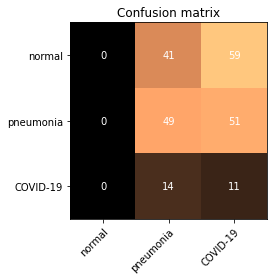

In [106]:
cm = confusion_matrix(validation_generator.classes, y_pred_classes)
print(cm)
plot_confusion_matrix(cm, target_names)

### Classification report

In [107]:
print(classification_report(validation_generator.classes, y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.00      0.00      0.00       100
   pneumonia       0.47      0.49      0.48       100
    COVID-19       0.09      0.44      0.15        25

    accuracy                           0.27       225
   macro avg       0.19      0.31      0.21       225
weighted avg       0.22      0.27      0.23       225



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Porównanie wyników z artykułem

Wyniki zostały porównane z artykułem https://www.nature.com/articles/s41598-020-76550-z, w którym zamieszczona jest analiza wykorzystania sieci COVID-Net do rozpoznawania przypadków COVID-19 na podstawie zdjęć rentgenowskich klatki piersiowej.

Do porównania z projektu została użyta sieć MobileNet V2 o parametrach: 
- rozmiar obrazka podawanego przy uczeniu: 64 px
- batch size: 16

## Dokładność na zbiorze testowym
- Sieć ResNet-50 z artykułu: 90.6 %
- Sieć COVID-Net z artykułu: 93.3 %
- Sieć MobileNet V2 z projektu: 14.67 %

Confuxion matrix z artykułu:

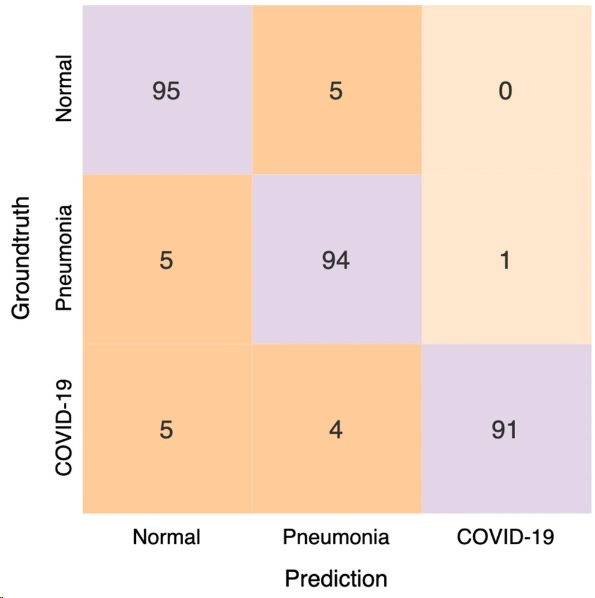

Confusion matrix uzyskany przez nas w projekcie:

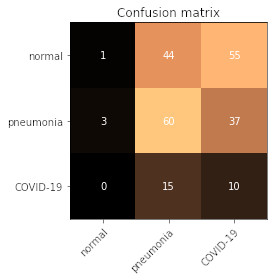

Jak można zauważyć, sieć z artykułu daje całkiem zadowalające rezultaty, czego nie można powiedzieć o sieci wytrenowanej przy okazji projektu. Confusion matrix, przypomina bardziej losowe zgadywanie, niż faktycze poprawne rozpoznawanie obrazów.

# Wnioski

Z macierzy od razu wynika, że projekt nie działa jak powinien. Główny problem pojawia się przy klasie 'normal', gdyż żaden model prawie wcale nie klasyfikuje do niej danych. Według wykresów zły wynik nie zależy od uzytej sieci, wszystkie mają podobną skutecznść, co pozwala wysnuć wniosek, że problemem może być zbyt mała liczba warstw własnych w modelu, i do poprawnego działania należałoby użyć ich więcej. Wartość dokładności w procesie uczenia stobilizowałą się po już kilku epokach, więc nie ma powodu, by dawać ich więcej.